# NLP - ML

In [10]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('.')

import os
import pandas as pd
import numpy as np
import nltk
nltk.data.path.append('/mnt/hdd1/Model/nltk_data')
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from spacy.lang.en import English
import matplotlib.pyplot as plt
from common.db import Neo4jDB

NEO4J_CONFIG = 'graph_db_ee'
NEO4J_DB='telemetry'

neo4jdb = Neo4jDB(config_name=NEO4J_CONFIG, database=NEO4J_DB)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
cypher1 = '''MATCH (dr:DispatchRaw)<--(d:Dispatch)-->(f:Failure)
WHERE dr.classify3='(bootup)no power'
RETURN dr.contact_title AS contact_title,
       dr.contact_text AS contact_text,
       dr.classify3 AS classify3
LIMIT 300
'''
data1 = neo4jdb.run_cypher(cypher1)
data1.drop_duplicates(subset='contact_text', inplace=True)

cypher2 = '''MATCH (dr:DispatchRaw)<--(d:Dispatch)-->(f:Failure)
WHERE dr.classify3='(bsod)bsod'
RETURN dr.contact_title AS contact_title,
       dr.contact_text AS contact_text,
       dr.classify3 AS classify3
LIMIT 300
'''
data2 = neo4jdb.run_cypher(cypher2)
data2.drop_duplicates(subset='contact_text', inplace=True)

data = pd.concat([data1.sample(25), data2.sample(25)])
data.reset_index(drop=True, inplace=True)

In [12]:
data['contact_text'].iloc[1]

'Additional ToXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX_x000D_BCC: _x000D_Attachment: _x000D__x000D_Subject: Dell Support: Case Number 179461202 from Robert Smith | ST: FRB8804    [ ref:!00D0b0GaMp.!5006P0C0Hgs:ref ]_x000D_Body:_x000D_Case Number: 179461202_x000D__x000D_Contact Us\xa0 \xa0|\xa0 \xa0Support Library\xa0 \xa0|\xa0 \xa0Download Center\xa0 \xa0|\xa0 \xa0SupportAssist\xa0 \xa0|\xa0 \xa0Community Forums_x000D__x000D_** Please Use Reply to All when replying to this emailXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX00D__x000D_I have included your service request information below:_x000D__x000D_Your Service Tag:\xa0FRB8804_x000D_Your Case Number:\xa0179461202_x000D__x000D_I will continue to be your service request owner and primary point of contact until your support need with Dell is completely resolved. If you need anything at all please reach me directly by replying to this emailXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXhoosing Dell Technologies._x000D__x000D_Robert Smith_x000D_Senior Technician_x000D_Dell Techno

## Preprocess

In [39]:
# === Raw Data ===
text_raw = 'Power and Startup. Customer: Power and Startup_x000D_\nNext Activity Added to this Call_Text!! \
00T6P00000thsUMUAY _x000D_\nno response from the other line. call dc after ghost call \
spiel_x000D__x000D__x000D_#BeginSolutionLogging_x000D_start_time_utc: 2023-11-13 16:39:36 \
|_x000D_session_id: 43260156-c66c-4180-8bea-7255ece7b170 |_x000D_language: en |_x000D_asst_id: 17M3BY3 \
|_x000D_Active open case: NOT-AVAILABLE |_x000D_lob_desc: Precision Notebooks |_x000D_brand_desc: \
PRECISION 5680 |_x000D_BKC status: False |_x000D_Symptom Description: ghost call - call disconnected - \
quick call |_x000D_Keywords: ghost, call, disconnected, quick |_x000D_Paused Flow Exist: No |_x000D_Paused \
Flow Selected: No |_x000D_External ID: NOT-AVAILABLE |_x000D_\
Next Best Action_x000D_e-mailXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
print(text_raw)

Power and Startup. Customer: Power and Startup_x000D_
Next Activity Added to this Call_Text!! 00T6P00000thsUMUAY _x000D_
no response from the other line. call dc after ghost call spiel_x000D__x000D__x000D_#BeginSolutionLogging_x000D_start_time_utc: 2023-11-13 16:39:36 |_x000D_session_id: 43260156-c66c-4180-8bea-7255ece7b170 |_x000D_language: en |_x000D_asst_id: 17M3BY3 |_x000D_Active open case: NOT-AVAILABLE |_x000D_lob_desc: Precision Notebooks |_x000D_brand_desc: PRECISION 5680 |_x000D_BKC status: False |_x000D_Symptom Description: ghost call - call disconnected - quick call |_x000D_Keywords: ghost, call, disconnected, quick |_x000D_Paused Flow Exist: No |_x000D_Paused Flow Selected: No |_x000D_External ID: NOT-AVAILABLE |_x000D_Next Best Action_x000D_e-mailXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [34]:
# === 步驟一: 移除stop words ===
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#英文的停用詞表
stop_words = set(stopwords.words('english'))

#將文本分詞
text_words = text_raw.split(' ')

#去除停用詞
key_words = []
for word in text_words:
    if word.lower() not in stop_words:
        key_words.append(word)
#filtered_words = [word for word in words if word.lower() not in stop_words]

text_clean = ' '.join(key_words)
print(text_clean)



hi_x000D__x000D_Dell Technical Support- NA : Welcome Dell Technologies Virtual Assistant._x000D__x000D_Dell Technical Support- NA : learn Dell’s privacy statement _x000D_regarding customer information here: https://dell.to/3p2YjEH_x000D__x000D_Dell Technical Support- NA : see contacting us Service _x000D_Tag: HNSPMW2_x000D__x000D_Dell Technical Support- NA : Card | correct Service Tag? | Yes, No_x000D__x000D_MH : No_x000D__x000D_Dell Technical Support- NA : Please type share photo Service Tag _x000D_or Express Code label review system configuration._x000D__x000D_MH : 1M1KDY3_x000D__x000D_Dell Technical Support- NA : appreciate recent purchase look _x000D_forward assisting you._x000D__x000D_Dell Technical Support- NA : ListPicker | Please select issue _x000D_following options: | issue listed, could please briefly _x000D_explain issue below? | Tap view | | New computer setup, McAfee _x000D_activation, MS Office activation, Slow performance, power issue_x000D__x000D_MH : Slow performance 

[nltk_data] Downloading package stopwords to /home/tpe-aa-
[nltk_data]     nb1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# === 步驟二: 還原_X000D_
text_clean = text_clean.replace('_x000D_', '\n')
print(text_clean)


hi

Dell Technical Support- NA : Welcome Dell Technologies Virtual Assistant.

Dell Technical Support- NA : learn Dell’s privacy statement 
regarding customer information here: https://dell.to/3p2YjEH

Dell Technical Support- NA : see contacting us Service 
Tag: HNSPMW2

Dell Technical Support- NA : Card | correct Service Tag? | Yes, No

MH : No

Dell Technical Support- NA : Please type share photo Service Tag 
or Express Code label review system configuration.

MH : 1M1KDY3

Dell Technical Support- NA : appreciate recent purchase look 
forward assisting you.

Dell Technical Support- NA : ListPicker | Please select issue 
following options: | issue listed, could please briefly 
explain issue below? | Tap view | | New computer setup, McAfee 
activation, MS Office activation, Slow performance, power issue

MH : Slow performance Computer working slow

Dell Technical Support- NA : Virtual Assistant designed answer 
questions resolve complex computer issues. Please follow 
troubleshooting s

In [24]:
# === 步驟三: 移除機敏資訊遮罩
import re
text_clean = re.sub(r'X+', '', text_clean)
print(text_clean)


Power Startup. Customer: Power Startup

Next Activity Added Call_Text!! 00T6P00000thsUMUAY 

no response line. call dc ghost call spiel


#BeginSolutionLogging
start_time_utc: 2023-11-13 16:39:36 |
session_id: 43260156-c66c-4180-8bea-7255ece7b170 |
language: en |
asst_id: 17M3BY3 |
Active open case: NOT-AVAILABLE |
lob_desc: Precision Notebooks |
brand_desc: PRECISION 5680 |
BKC status: False |
Symptom Description: ghost call - call disconnected - quick call |
Keywords: ghost, call, disconnected, quick |
Paused Flow Exist: |
Paused Flow Selected: |
External ID: NOT-AVAILABLE |
Next Best Action
e-mail


In [17]:
# === 步驟四: 整合程式, 並套用到所有資料 ===
def text_preprocess(text_raw):
    #將文本分詞
    words = text_raw.split(' ')
    #去除停用詞
    filtered_words = [word for word in words if word.lower() not in stop_words]
    text_clean = ' '.join(filtered_words)
    # 還原特殊符號
    text_clean = text_clean.replace('_x000D_', '\n')
    text_clean = text_clean.replace('_x0009_', ' ')
    # 移除機敏資訊遮罩
    text_clean = re.sub(r'X+', '', text_clean)
    return text_clean

data['text_clean'] = data['contact_text'].map(lambda x: text_preprocess(x))
pd.set_option("display.max_colwidth", 70)
data[['contact_text','text_clean']]

,contact_text,text_clean
0,文磊 : _x000D_https://sprcdn-assets.sprinklr.com/105/69740ee1-f66e-4...,文磊 : \nhttps://sprcdn-assets.sprinklr.com/105/69740ee1-f66e-4e0a-9...
1,Additional ToXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX_x000D_BCC: _x000D_Atta...,Additional To\nBCC: \nAttachment: \n\nSubject: Dell Support: Case ...
2,1 power button sunken_x000D_2 BR2 NOMEL_x000D_3 PC NOMEL _x000D_4 ...,1 power button sunken\n2 BR2 NOMEL\n3 PC NOMEL \n4 DAMAGE\n5REPLAC...
3,Servicetag: DGV2DY3_x000D_#HALPRO no power // PREC 5680_x000D__x00...,Servicetag: DGV2DY3\n#HALPRO power // PREC 5680\n\nProblem/TS: \n\...
4,"its not powering on, _x000D__x000D_1. checked with another charger...","powering on, \n\n1. checked another charger -- luck, showing charg..."
5,CMG Routing Team - Call Transferred_x000D__x000D_Pro Support_x000D...,CMG Routing Team - Call Transferred\n\nPro Support\n\nNext Activit...
6,Power and Startup_x000D_\nNext Activity Added to this Call_Text!! ...,Power Startup\n\nNext Activity Added Call_Text!! 00T6P00000tla9HUA...
7,Arturo : Buenas tardes_x000D__x000D_Dell Soporte Tecnico : Bienven...,Arturo : Buenas tardes\n\nDell Soporte Tecnico : Bienvenido al asi...
8,Additional ToXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX000D_BCC: _x000D_Attach...,Additional To000D_BCC: \nAttachment: \n\nSubject: Dell Support: Ca...
9,No Power. Troubleshooting Performed = No Power / Tried Power drain...,Power. Troubleshooting Performed = Power / Tried Power drain .. Tr...


### Freature Engineering


In [18]:
#步驟一: 計算出現頻率最高的20個字

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=20)
X = vectorizer.fit(data['text_clean'])
high_freq_words = vectorizer.get_feature_names_out()
print("High Frequency Words:")
print(high_freq_words)

High Frequency Words:
['additional' 'attachment' 'case' 'code' 'com' 'contact' 'de' 'dell' 'id'
 'issue' 'number' 'please' 'power' 'ref' 'service' 'support' 'system'
 'technologies' 'us' 'working']


In [19]:
#步驟二: 從文本中計算特徵 (高頻字的出現次數)
feature_matrix = vectorizer.transform([text_clean])
dense_matrix = feature_matrix.toarray()
columns = vectorizer.get_feature_names_out()
df = pd.DataFrame(dense_matrix, columns=columns)
display(df)

,additional,attachment,case,code,com,contact,de,dell,id,issue,number,please,power,ref,service,support,system,technologies,us,working
0,0,0,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0


In [20]:
#步驟三: 整合程式, 並套用到所有資料 ===
X = vectorizer.transform(data['text_clean'])


### Decision Tree Model Training

In [21]:
#步驟一: 將資料區分成訓練資料與測試資料 (就跟考試一樣, 先用訓練資料讓模型學習, 再用測試資料確認模型的準確率)
from sklearn.model_selection import train_test_split

data_tr,  data_ts = train_test_split(data, test_size=0.2, stratify=data['classify3'])

In [22]:
#步驟二: 訓練模型
from sklearn.tree import DecisionTreeClassifier

vectorizer = CountVectorizer(max_features=20)
X = vectorizer.fit_transform(data_tr['text_clean'])
classifier = DecisionTreeClassifier(max_depth=1)
classifier.fit(X, data_tr['classify3'].values)

DecisionTreeClassifier(max_depth=1)

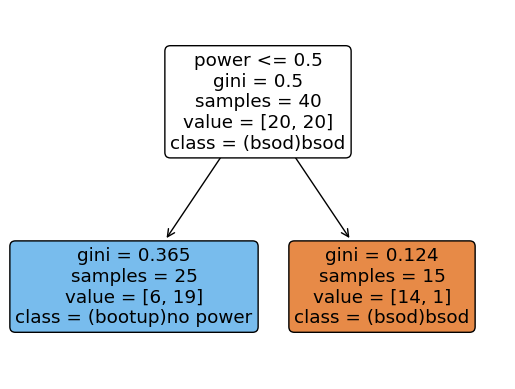

In [25]:
#步驟三: 檢視Decision Tree規則
from sklearn.tree import DecisionTreeClassifier, plot_tree

plot_tree(classifier, 
          feature_names=vectorizer.get_feature_names_out(), 
          class_names=data_tr['classify3'].unique(), 
          filled=True, 
          rounded=True)
plt.show()


In [26]:
#步驟四: 用測試資料確認模型的準確率
from sklearn.metrics import accuracy_score

X_ts = vectorizer.fit_transform(data_ts['text_clean'])
y_pred = classifier.predict(X_ts)
accuracy = accuracy_score(data_ts['classify3'].values, y_pred)
report = classification_report(data_ts['classify3'].values, y_pred)
print(f'testset size: {X_ts.shape[0]}')
print(f'accuracy: {accuracy}')
print(report)

testset size: 10
accuracy: 0.7
                  precision    recall  f1-score   support

(bootup)no power       0.75      0.60      0.67         5
      (bsod)bsod       0.67      0.80      0.73         5

        accuracy                           0.70        10
       macro avg       0.71      0.70      0.70        10
    weighted avg       0.71      0.70      0.70        10

